# The Battle of Neighborhoods (Week 2)


In this assignment we will do some researches from Toronto city's data for new restaurants

## Introduction


In this assignment we will do some researches from Toronto city's data to find a new restaurant in Toronto.

First, we will try to find the best location which someone wants to open a new restaurant in the city, and which types of income group will be attracted most to it based on the population of the neighbourhood.



## Business Problem

### Background
Toronto is the provincial capital of Ontario and the most populous city in Canada and the fourth most populous city in North America, which is with a population of 2,731,571 in 2016. The Toronto census metropolitan area (CMA), of which the majority is within the Greater Toronto Area (GTA), held a population of 5,928,040, making it Canada's most populous CMA. Toronto is the fastest growing city in North America. and is the anchor of an urban agglomeration, known as the Golden Horseshoe in Southern Ontario, located on the northwestern shore of Lake Ontario.

Toronto encompasses a geographical area formerly administered by many separate municipalities. Former municipalities include East York, Etobicoke, Forest Hill, Mimico, North York, Parkdale, Scarborough, Swansea, Weston and York. Throughout the city there exist hundreds of small neighbourhoods and some larger neighbourhoods covering a few square kilometres.

There is vast population and big geographical area, there also exists big competition between businesses. Therefore it became very challenging for stake holder or new business to decide which area they should start their business to get higher revenue with lowest possible competition.


### Purpose
Target Audience: \
New Business who wants to open a restaurant in Toronto.

The objective of this report is to determine the best possible location to open a Restaurant in Toronto, based on the different localities of the city, already established restaurants in varios geographical location and ease of accessibility by maximum number of people so that the revenue from the latest venture can be maximized.

Therefore I focus on that borough during my analysis. We define potential neighborhood based on the number of restaurant which are operating right in each neighborhood. Toronto has full potential but also is a very challenging district to open a business because of high competition. New restaurant should be open in an area that inadequate neighborhood in this way the restaurant can attract more customers. Therefore, this analysis necessary to ensure that we have enough customers and that we are not so close to other restaurants places.

### data
In this assignment we will do some researches from Toronto city's data.

First, we will try to find the best location which someone wants to open a new restaurant in the city, and which types of income group will be attracted most to it based on the population of the neighbourhood.

For my analysis I choose some data resources:\
1、City of Toronto Neighbourhood Profiles use this Census data to provide a portrait of the demographic, social and economic characteristics of the people and households in each City of Toronto neighbourhood. \
The profiles present selected highlights from the data, but these accompanying data files provide the full data set assembled for each neighbourhood.\

Link: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"


2、Using foursquare data to get information about restaurants in Toronto

Link: https://foursquare.com/explore?mode=url&ne=44.418088%2C-78.362732&q=Restaurant&sw=42.742978%2C-80.554504

3、Load Toronto geospatial coordinates and merge to Toronto Postal Code Data

Link: http://cocl.us/Geospatial_data

4、Toronto neighborhoods populations broken down by postal code

Link：https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Tables/File.cfm?T=1201&SR=1&RPP=9999&PR=0&CMA=0&CSD=0&S=22&O=A&Lang=Eng&OFT=CSV

5、Toronto neighborhoods average after tax income broken down by postal code

Canadian families and unattached individuals had a median after-tax income of $57,000 in 2016.

Link： https://www150.statcan.gc.ca/n1/daily-quotidien/180313/dq180313a-eng.htm



### Approach
1、Collect the Toronto city data from Wikipedia.\
2、Using FourSquare API we will find all venues for each neighborhood.\
3、Filter out all venues that are nearby by locality.\
4、Using aggregative rating for each resturant to find the best places.\
5、Visualize the Ranking of neighborhoods using folium library(python)

## Import necessary libraries

In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
import urllib.request
import json
from bs4 import BeautifulSoup
from urllib.request import urlopen
import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes
import folium

print('Libraries imported.')

Libraries imported.


In [4]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

soup = BeautifulSoup(source, 'html.parser')
tablesoup = soup.find('table', class_ = 'wikitable sortable')

column_names = ['Postalcode','Borough','Neighborhood']
df = pd.DataFrame(columns = column_names)

for tr_cell in tablesoup.find_all('tr'):
    row_data=[]
    for td_cell in tr_cell.find_all('td'):
        row_data.append(td_cell.text.strip())
    if len(row_data)==3:
        df.loc[len(df)] = row_data

In [18]:
df=df[df['Borough']!='Not assigned']
df2=df.groupby(['Postalcode', 'Borough']).apply(lambda group: ', '.join(group['Neighborhood']))
df2=df2.to_frame().reset_index()

In [20]:
df2 = df2.rename(columns={0:'Neighborhood'})
df2.loc[df2.Neighborhood == 'Not assigned', 'Neighborhood' ] = df2.Borough

In [21]:
df2.head()

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [36]:
#Load Toronto geospatial coordinates and merge to Toronto Postal Code Data
geosoup=pd.read_csv('http://cocl.us/Geospatial_data')

In [40]:
geosoup.head()
gf = geosoup.rename(columns={'Postal Code':'Postalcode'})
gf= pd.merge(df2, gf, on='Postalcode', how='inner')
gf.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [63]:
#Toronto neighborhoods populations broken down by postal code

df_pop = pd.read_csv('T120120210204041730.csv',encoding = 'unicode_escape')
df_pop = df_pop.rename(columns={'Geographic code':'Postalcode', 'Geographic name':'Postalcode2', 'Province or territory':'Province', 'Incompletely enumerated Indian reserves and Indian settlements, 2016':'Incomplete', 'Population, 2016':'Population_2016', 'Total private dwellings, 2016':'TotalPrivDwellings', 'Private dwellings occupied by usual residents, 2016':'PrivDwellingsOccupied'})
df_pop= df_pop.drop(columns=['Postalcode2', 'Province', 'Incomplete', 'TotalPrivDwellings', 'PrivDwellingsOccupied'])
df_pop = df_pop.iloc[1:]
df_pop.head()

,Postalcode,Population_2016
1,A0A,46587.0
2,A0B,19792.0
3,A0C,12587.0
4,A0E,22294.0
5,A0G,35266.0


In [64]:
#Merge Toronto Neighbourhood population data with Toronto Postal code data
gf= pd.merge(df_pop, gf, on='Postalcode', how='right')

gf= gf.sort_values(by=['Population_2016'], ascending=False)

# display the new dataframe
gf.head()

,Postalcode,Population_2016,Borough,Neighborhood,Latitude,Longitude
22,M2N,75897.0,North York,"Willowdale, Willowdale East",43.770120,-79.408493
0,M1B,66108.0,Scarborough,"Malvern, Rouge",43.806686,-79.194353
18,M2J,58293.0,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556
101,M9V,55959.0,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437
14,M1V,54680.0,Scarborough,"Milliken, Agincourt North, Steeles East, L'Amo...",43.815252,-79.284577


In [98]:
#Toronto neighborhoods average after tax income broken down by postal code
#Merge Toronto Neighbourhood income data with Toronto Postal Code data
df_income = pd.read_csv('TOincome.csv',encoding = 'unicode_escape')
df_income = df_income.rename(columns={"after-tax income of households in 2015":"AfterTaxIncome2015","PostalCode":"Postalcode"})
df_income.head()


,Unnamed: 0,Postalcode,AfterTaxIncome2015,Population_2016,Bourough,Neighborhood,Latitude,Longitude
0,66,M2P,115237.0,7843.0,North York,York Mills West,43.752758,-79.400049
1,55,M5M,111821.0,25975.0,North York,"Bedford Park, Lawrence Manor East",43.733283,-79.419750
2,61,M4N,109841.0,15330.0,Central Toronto,Lawrence Park,43.728020,-79.388790
3,74,M5R,108271.0,26496.0,Central Toronto,"The Annex, North Midtown, Yorkville",43.672710,-79.405678
4,98,M8X,97210.0,10787.0,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944


In [99]:
#Toronto list of Restaurants or Venues that could potentially use Restaurant Equipment
CLIENT_ID = 'MFZD5IICKPB0K2EPMN3T4H1NI2AFB0GEDTLVADEUU2RW3HGW' # your Foursquare ID
CLIENT_SECRET = '3V2W0GDZXELVDR13XX31IP5BVJUVKZB2RU5PMEHCYTNVYS0B' # your Foursquare Secret
VERSION = '20201106'

In [100]:
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

LIMIT = 200 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)

        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

        results = requests.get(url).json()["response"]['groups'][0]['items']

        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [102]:
# Toronto Bouroughs
TOdata = df_income
TOdata.head()

,Unnamed: 0,Postalcode,AfterTaxIncome2015,Population_2016,Bourough,Neighborhood,Latitude,Longitude
0,66,M2P,115237.0,7843.0,North York,York Mills West,43.752758,-79.400049
1,55,M5M,111821.0,25975.0,North York,"Bedford Park, Lawrence Manor East",43.733283,-79.419750
2,61,M4N,109841.0,15330.0,Central Toronto,Lawrence Park,43.728020,-79.388790
3,74,M5R,108271.0,26496.0,Central Toronto,"The Annex, North Midtown, Yorkville",43.672710,-79.405678
4,98,M8X,97210.0,10787.0,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944


In [104]:
TO_venues = getNearbyVenues(names=TOdata['Neighborhood'],
                                   latitudes=TOdata['Latitude'],
                                   longitudes=TOdata['Longitude']
                                  )

York Mills West
Bedford Park, Lawrence Manor East
Lawrence Park
The Annex, North Midtown, Yorkville
The Kingsway, Montgomery Road, Old Mill North
Silver Hills, York Mills
Leaside
Highland Creek, Rouge Hill, Port Union
Cloverdale, Islington, Martin Grove, Princess Gardens, West Deane Park
Don Mills North
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
East Toronto
Upper Rouge
Birch Cliff, Cliffside West
Little Portugal, Trinity
Rosedale
Moore Park, Summerhill East
Roselawn
The Beaches
Kingsway Park South West, Mimico NW, The Queensway West, Royal York South West, South of Bloor
North Toronto West
Runnymede, Swansea
Berczy Park
Forest Hill North, Forest Hill West
Woodbine Heights
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Harbourfront East, Toronto Islands, Union Station
Adelaide, King, Richmond
St. James Town
The Beaches West, India Bazaar
Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe
Kings

In [108]:
TO_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",93,93,93,93,93,93
Agincourt,4,4,4,4,4,4
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",3,3,3,3,3,3
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",9,9,9,9,9,9
"Alderwood, Long Branch",8,8,8,8,8,8


In [110]:
# Let's pick out restaurants from Venue Categories

print('Unique Venue Categories:')
list(TO_venues['Venue Category'].unique())

Unique Venue Categories:


['Convenience Store',
 'Park',
 'Construction & Landscaping',
 'Bar',
 'Café',
 'Restaurant',
 'Indian Restaurant',
 'Italian Restaurant',
 'Sushi Restaurant',
 'Pub',
 'Thai Restaurant',
 'Juice Bar',
 'Comfort Food Restaurant',
 'Greek Restaurant',
 'Coffee Shop',
 'Pharmacy',
 'Sandwich Place',
 'Grocery Store',
 'Liquor Store',
 'Butcher',
 'American Restaurant',
 'Pizza Place',
 'Business Service',
 'Swim School',
 'Bus Line',
 'Burger Joint',
 'BBQ Joint',
 'Middle Eastern Restaurant',
 'History Museum',
 'Donut Shop',
 'Pool',
 'River',
 'Sports Bar',
 'Sporting Goods Shop',
 'Fish & Chips Shop',
 'Bike Shop',
 'Supermarket',
 'Pet Store',
 'Smoothie Shop',
 'Shopping Mall',
 'Bank',
 'Dessert Shop',
 'Brewery',
 'Department Store',
 'Beer Store',
 'Breakfast Spot',
 'Furniture / Home Store',
 'Electronics Store',
 'Mexican Restaurant',
 'Bagel Shop',
 'Peking Duck Restaurant',
 'Bakery',
 'Caribbean Restaurant',
 'Gym',
 'Japanese Restaurant',
 'Baseball Field',
 'Athletics & S

In [112]:
# Here we manually pick out restaurants or 'features' from the unique venue list and that we want to examine for similiarity during clustering
rest_list = ['Steakhouse', 'Coffee Shop', 'Café', 'Ramen Restaurant', 'Indonesian Restaurant', 'Restaurant', 'Japanese Restaurant', 
             'Fast Food Restaurant', 'Sushi Restaurant', 'Vietnamese Restaurant', 'Pizza Place', 'Sandwich Place', 'Middle Eastern Restaurant', 
             'Burger Joint', 'American Restaurant', 'Food Court', 'Wings Joint', 'Burrito Place', 'Asian Restaurant', 'Deli / Bodega', 
             'Greek Restaurant', 'Fried Chicken Joint', 'Airport Food Court', 'Chinese Restaurant', 'Breakfast Spot', 'Mexican Restaurant',
             'Indian Restaurant', 'Latin American Restaurant', 'Bar', 'Pub', 'Italian Restaurant', 'French Restaurant', 'Ice Cream Shop', 
             'Caribbean Restaurant', 'Gastropub', 'Thai Restaurant', 'Cajun / Creole Restaurant', 'Diner', 'Dim Sum Restaurant', 'Seafood Restaurant', 
             'Food & Drink Shop', 'Noodle House', 'Food', 'Fish & Chips Shop', 'Falafel Restaurant', 'Gourmet Shop', 'Vegetarian / Vegan Restaurant', 
             'South American Restaurant', 'Korean Restaurant', 'Cuban Restaurant', 'New American Restaurant', 'Malay Restaurant', 'Mac & Cheese Joint',
             'Bistro', 'Southern / Soul Food Restaurant', 'Tapas Restaurant',  'Sports Bar', 'Polish Restaurant', 'Ethiopian Restaurant', 
             'Creperie', 'Sake Bar', 'Persian Restaurant', 'Afghan Restaurant','Mediterranean Restaurant', 'BBQ Joint', 'Jewish Restaurant', 
             'Comfort Food Restaurant',  'Hakka Restaurant', 'Food Truck', 'Taiwanese Restaurant',  'Snack Place', 'Eastern European Restaurant', 
             'Dumpling Restaurant', 'Belgian Restaurant', 'Arepa Restaurant', 'Taco Place', 'Doner Restaurant', 'Filipino Restaurant', 
             'Hotpot Restaurant', 'Poutine Place', 'Salad Place',  'Portuguese Restaurant', 'Modern European Restaurant', 'Empanada Restaurant', 
             'Irish Pub', 'Molecular Gastronomy Restaurant', 'German Restaurant', 'Brazilian Restaurant', 'Gluten-free Restaurant', 'Soup Place']

rest_pd = pd.DataFrame(rest_list)
#rest_pd
#rename the coloumns so the match
rest_pd = rest_pd.rename(columns={0:'Venue Category'})

#Join the 2 dataframes as instructed
TO_new = pd.merge(TO_venues, rest_pd, on='Venue Category', how='right')

# display the new dataframe
#TO_new

TO_new.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",55,55,55,55,55,55
Agincourt,2,2,2,2,2,2
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",5,5,5,5,5,5
"Alderwood, Long Branch",4,4,4,4,4,4
"Bathurst Manor, Downsview North, Wilson Heights",11,11,11,11,11,11


In [113]:
# onehot encoding and count restaurants
TO_new_onehot = pd.get_dummies(TO_new[['Venue Category']], prefix="", prefix_sep="")

TO_new_onehot['Neighborhood'] = TO_new['Neighborhood'] 


fixed_columns = [TO_new_onehot.columns[-1]] + list(TO_new_onehot.columns[:-1])
TO_new_onehot = TO_new_onehot[fixed_columns]
TO_new_onehot.head()

,Neighborhood,Afghan Restaurant,Airport Food Court,American Restaurant,Arepa Restaurant,Asian Restaurant,BBQ Joint,Bar,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Burger Joint,Burrito Place,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Coffee Shop,Comfort Food Restaurant,Creperie,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Hakka Restaurant,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Korean Restaurant,Latin American Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,Noodle House,Persian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Restaurant,Sake Bar,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Sports Bar,Steakhouse,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Berczy Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,"Harbourfront East, Toronto Islands, Union Station",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,"Adelaide, King, Richmond",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,"Adelaide, King, Richmond",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,"The Beaches West, India Bazaar",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [115]:
#Analyze each neighbourhood
TO_grouped = TO_new_onehot.groupby('Neighborhood').mean().reset_index()
TO_grouped.shape

TO_grouped.head()

,Neighborhood,Afghan Restaurant,Airport Food Court,American Restaurant,Arepa Restaurant,Asian Restaurant,BBQ Joint,Bar,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Burger Joint,Burrito Place,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Coffee Shop,Comfort Food Restaurant,Creperie,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Hakka Restaurant,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Korean Restaurant,Latin American Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,Noodle House,Persian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Restaurant,Sake Bar,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Sports Bar,Steakhouse,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,"Adelaide, King, Richmond",0.0,0.0,0.036364,0.0,0.018182,0.0,0.018182,0.0,0.0,0.018182,0.018182,0.018182,0.036364,0.090909,0.0,0.0,0.0,0.163636,0.0,0.0,0.0,0.054545,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.018182,0.0,0.0,0.0,0.0,0.018182,0.0,0.0,0.000000,0.018182,0.0,0.018182,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.018182,0.0,0.0,0.018182,0.0,0.0,0.018182,0.0,0.000000,0.018182,0.0,0.018182,0.018182,0.0,0.036364,0.0,0.0,0.0,0.00,0.0,0.072727,0.0,0.036364,0.018182,0.018182,0.0,0.018182,0.0,0.0,0.0,0.036364,0.036364,0.0,0.0,0.0,0.054545,0.018182,0.0,0.0
1,Agincourt,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.500000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.500000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.200000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.400000,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,0.200000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
3,"Alderwood, Long Branch",0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.500000,0.0,0.0,0.0,0.25,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
4,"Bathurst Manor, Downsview North, Wilson Heights",0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.181818,0.0,0.0,0.0,0.090909,0.0,0.090909

## Finde optimal number of Cluster  to segment the data

In [121]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

TO_grouped_clustering = TO_grouped.drop('Neighborhood', 1)

# Use silhouette score to find optimal number of clusters to segment the data
kclusters = np.arange(2,10)
results = {}
for size in kclusters:
    model = KMeans(n_clusters = size).fit(TO_grouped_clustering)
    predictions = model.predict(TO_grouped_clustering)
    results[size] = silhouette_score(TO_grouped_clustering, predictions)

best_size = max(results, key=results.get)
best_size

2

## Run K means and segment data into clusters and generate labels

In [122]:
#import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = best_size


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(TO_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [123]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = TO_grouped['Neighborhood']

for ind in np.arange(TO_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(TO_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Restaurant,Thai Restaurant,Deli / Bodega,Steakhouse,Salad Place,Pizza Place,Burrito Place,Sushi Restaurant
1,Agincourt,Breakfast Spot,Latin American Restaurant,Food,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant
2,"Albion Gardens, Beaumond Heights, Humbergate, ...",Pizza Place,Fast Food Restaurant,Fried Chicken Joint,Sandwich Place,Wings Joint,Diner,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
3,"Alderwood, Long Branch",Pizza Place,Pub,Coffee Shop,Wings Joint,Diner,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant
4,"Bathurst Manor, Downsview North, Wilson Heights",Coffee Shop,Pizza Place,Sandwich Place,Diner,Fried Chicken Joint,Ice Cream Shop,Middle Eastern Restaurant,Sushi Restaurant,Restaurant,Deli / Bodega


In [125]:
#Merge the Toronto data with geo cooridinate data and make sure it's the right shape
TO_labels = pd.merge(TOdata,TO_grouped, on='Neighborhood', how='right')
TO_labels.shape


TO_labels = TO_labels.drop(columns=['Steakhouse', 'Coffee Shop', 'Café', 'Ramen Restaurant', 'Indonesian Restaurant', 'Restaurant', 'Japanese Restaurant', 
             'Fast Food Restaurant', 'Sushi Restaurant', 'Vietnamese Restaurant', 'Pizza Place', 'Sandwich Place', 'Middle Eastern Restaurant', 
             'Burger Joint', 'American Restaurant', 'Food Court', 'Wings Joint', 'Burrito Place', 'Asian Restaurant', 'Deli / Bodega', 
             'Greek Restaurant', 'Fried Chicken Joint', 'Airport Food Court', 'Chinese Restaurant', 'Breakfast Spot', 'Mexican Restaurant',
             'Indian Restaurant', 'Latin American Restaurant', 'Bar', 'Pub', 'Italian Restaurant', 'French Restaurant', 'Ice Cream Shop', 
             'Caribbean Restaurant', 'Gastropub', 'Thai Restaurant', 'Cajun / Creole Restaurant', 'Diner', 'Dim Sum Restaurant', 'Seafood Restaurant', 
             'Food & Drink Shop', 'Noodle House', 'Food', 'Fish & Chips Shop', 'Falafel Restaurant', 'Gourmet Shop', 'Vegetarian / Vegan Restaurant', 
             'South American Restaurant', 'Korean Restaurant', 'Cuban Restaurant', 'New American Restaurant', 'Malay Restaurant', 'Mac & Cheese Joint',
             'Bistro', 'Southern / Soul Food Restaurant', 'Tapas Restaurant',  'Sports Bar', 'Polish Restaurant', 'Ethiopian Restaurant', 
             'Creperie', 'Sake Bar', 'Persian Restaurant', 'Afghan Restaurant','Mediterranean Restaurant', 'BBQ Joint', 'Jewish Restaurant', 
             'Comfort Food Restaurant',  'Hakka Restaurant', 'Food Truck', 'Taiwanese Restaurant',  'Snack Place', 'Eastern European Restaurant', 
             'Dumpling Restaurant', 'Belgian Restaurant', 'Arepa Restaurant', 'Taco Place', 'Doner Restaurant', 'Filipino Restaurant', 
             'Hotpot Restaurant', 'Poutine Place', 'Salad Place',  'Portuguese Restaurant', 'Modern European Restaurant', 'Empanada Restaurant', 
             'Irish Pub', 'Molecular Gastronomy Restaurant', 'German Restaurant', 'Brazilian Restaurant', 'Gluten-free Restaurant', 'Soup Place'])
TO_labels.head()

,Unnamed: 0,Postalcode,AfterTaxIncome2015,Population_2016,Bourough,Neighborhood,Latitude,Longitude
0,30,M5H,70571.0,2005.0,Downtown Toronto,"Adelaide, King, Richmond",43.650571,-79.384568
1,78,M1S,57738.0,37769.0,Scarborough,Agincourt,43.794200,-79.262029
2,89,M9V,55443.0,55959.0,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ...",43.739416,-79.588437
3,93,M8W,63602.0,20674.0,Etobicoke,"Alderwood, Long Branch",43.602414,-79.543484
4,28,M3H,63342.0,37011.0,North York,"Bathurst Manor, Downsview North, Wilson Heights",43.754328,-79.442259


In [126]:
TO_merged = TO_labels

# add clustering labels
TO_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
TO_merged = TO_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

TO_merged.head() # check the last columns!

,Unnamed: 0,Postalcode,AfterTaxIncome2015,Population_2016,Bourough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,30,M5H,70571.0,2005.0,Downtown Toronto,"Adelaide, King, Richmond",43.650571,-79.384568,1,Coffee Shop,Café,Restaurant,Thai Restaurant,Deli / Bodega,Steakhouse,Salad Place,Pizza Place,Burrito Place,Sushi Restaurant
1,78,M1S,57738.0,37769.0,Scarborough,Agincourt,43.794200,-79.262029,1,Breakfast Spot,Latin American Restaurant,Food,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant
2,89,M9V,55443.0,55959.0,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ...",43.739416,-79.588437,1,Pizza Place,Fast Food Restaurant,Fried Chicken Joint,Sandwich Place,Wings Joint,Diner,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
3,93,M8W,63602.0,20674.0,Etobicoke,"Alderwood, Long Branch",43.602414,-79.543484,1,Pizza Place,Pub,Coffee Shop,Wings Joint,Diner,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant
4,28,M3H,63342.0,37011.0,North York,"Bathurst Manor, Downsview North, Wilson Heights",43.754328,-79.442259,1,Coffee Shop,Pizza Place,Sandwich Place,Diner,Fried Chicken Joint,Ice Cream Shop,Middle Eastern Restaurant,Sushi Restaurant,Restaurant,Deli / Bodega


In [127]:
TO_merged_new1 = TO_merged.loc[TO_merged['Cluster Labels'] == 0, TO_merged.columns[[3, 4] + list(range(5, TO_merged.shape[1]))]]
TO_merged_new1.shape

(4, 16)

In [128]:
TO_merged_new2 = TO_merged.loc[TO_merged['Cluster Labels'] == 1, TO_merged.columns[[3, 4] + list(range(5, TO_merged.shape[1]))]]
TO_merged_new2.shape

(76, 16)

## Cluster 2 Contains the highest cluster density. We need to find the geographic centroid for this cluster. This is the optimum location for a new Restaurant Supply Store.¶

In [136]:
# Find the geographic center of the most dense or like cluster.
Cluster_0_coorid = TO_merged_new2[['Latitude', 'Longitude']]
Cluster_0_coorid = list(Cluster_0_coorid.values) 
lat = []
long = []



for l in Cluster_0_coorid:
  lat.append(l[0])
  long.append(l[1])



Blatitude = sum(lat)/len(lat)
Blongitude = sum(long)/len(long)
print(Blatitude)
print(Blongitude)
print('The geograpical coordinate of Toronto are {}, {}.'.format(Blatitude, Blongitude))

43.69925233157894
-79.3898137513158
The geograpical coordinate of Toronto are 43.69925233157894, -79.3898137513158.


In [144]:
from opencage.geocoder import OpenCageGeocode
from pprint import pprint

key = 'fb8b1b84069c44599b03a06ffc1f36d3'
geocoder = OpenCageGeocode(key)

results = geocoder.reverse_geocode(Blatitude, Blongitude)
pprint(results)

[{'annotations': {'DMS': {'lat': "43° 41' 57.14628'' N",
                          'lng': "79° 23' 24.30168'' W"},
                  'MGRS': '17TPJ2972439724',
                  'Maidenhead': 'FN03hq37et',
                  'Mercator': {'x': -8837663.707, 'y': 5389481.08},
                  'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=31372743#map=16/43.69921/-79.39008',
                          'note_url': 'https://www.openstreetmap.org/note/new#map=16/43.69921/-79.39008&layers=N',
                          'url': 'https://www.openstreetmap.org/?mlat=43.69921&mlon=-79.39008#map=16/43.69921/-79.39008'},
                  'UN_M49': {'regions': {'AMERICAS': '019',
                                         'CA': '124',
                                         'NORTHERN_AMERICA': '021',
                                         'WORLD': '001'},
                             'statistical_groupings': ['MEDC']},
                  'callingcode': 1,
                  'currency': {'

In [145]:
#Obtain the popupstring of the best location
popstring = TOdata[TOdata['Postalcode'].str.contains('M4S')]

def str_join(*args):
    return ''.join(map(str, args))

popstring_new = str_join('The Best Neighbourhood to locate a Restaurant Supply Store is in: ', popstring['Neighborhood'].values,  ' in ' ,  popstring['Bourough'].values)


print(popstring_new)

The Best Neighbourhood to locate a Restaurant Supply Store is in: ['Davisville'] in ['Central Toronto']


In [150]:
from geopy.geocoders import Nominatim
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="geopy.geocoders.options.default_user_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [151]:
# getfolium
import folium 
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[Blatitude, Blongitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(TO_merged['Latitude'], TO_merged['Longitude'], TO_merged['Neighborhood'], TO_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
folium.CircleMarker([Blatitude, Blongitude],
                    radius=50,
                    popup='Toronto',
                    color='red',
                    ).add_to(map_clusters)

# Interactive marker
map_clusters.add_child(folium.ClickForMarker(popup=popstring_new))
       
#map_clusters
map_clusters.save('map_clusters.html')

# Result

In [148]:
print('The exact Address to locate would be: 268 Balliol Street, ON M4S 1C2, Canada or lat: 43.6991598, lng: -79.3878871')


The exact Address to locate would be: 268 Balliol Street, ON M4S 1C2, Canada or lat: 43.6991598, lng: -79.3878871


In [149]:
map_clusters


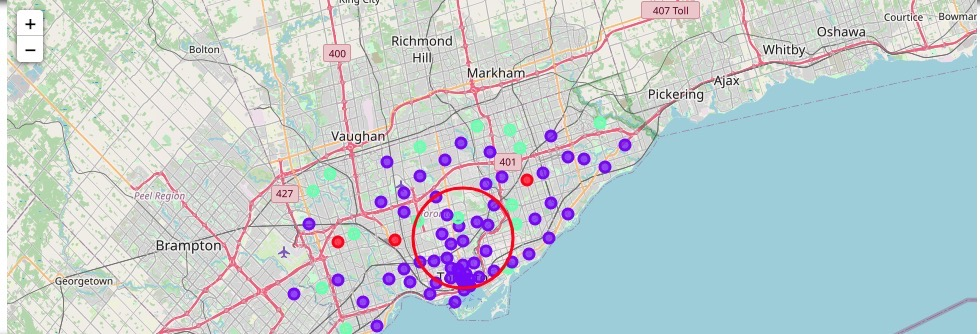